# Image classification of IBSC compliant vs Non-compliant using ConvNeXt


### What is ConvNeXt?
ConvNeXt (Convolutional Neural Network for the 2020s) is a modern convolutional neural network architecture introduced by Facebook AI Research (FAIR) in 2022. It was designed to challenge the dominance of Vision Transformers (ViTs) by showing that pure convolutional networks can still achieve state-of-the-art performance when designed with modern techniques.

### Goal of model 

We are building a model that can classify dashboard screenshots (or other images) as:

- Compliant — follows the IBCS guideline  
- Non-compliant — violates the chosen rule  

Hence, this is a binary classification problem.

### Model Definition

We start from a **pre-trained ConvNeXt Tiny model** (`convnext_tiny(pretrained=True)`) available in `torchvision.models`.  
This gives us a model that already knows general image features (edges, shapes, colors) from **ImageNet** training.


In [1]:
# %pip install torch 
# %pip install torchvision

## Import Libraries

In [2]:
import copy, pathlib, math
import PIL.Image as Image

import sklearn
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import torch
import torch.nn as nn
from torchvision import models as models
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
print("scikit-learn version:", sklearn.__version__)     # 1.1.3
print("np version:", np.__version__)              # 1.23.4
print("matplotlib version:", matplotlib.__version__)    # 3.6.2

scikit-learn version: 1.7.2
np version: 2.2.0
matplotlib version: 3.10.6


## Data Preparation

In [3]:
size = 300

def load_image(file, size):
    img = Image.open(file)
    img = img.resize((size, size))
    return np.array(img).flatten()

def load_labelled_images(path, size):
    labels = list()
    files = list()
    for file_info in [x for x in pathlib.Path(path).glob("**/*.jpg")]:
        labels.append(file_info.parts[1])
        files.append(str(file_info))
    imgs = np.array([load_image(f, size) for f in files])
    return imgs, np.array(labels)   

images, labels = load_labelled_images("./Scaling _dataset", size)
print("Loaded", len(images), "images in the following", len(np.unique(labels)), "classes:")
for label in np.unique(labels):
    print(label)


Loaded 41 images in the following 2 classes:
Compliant
Not Compliant


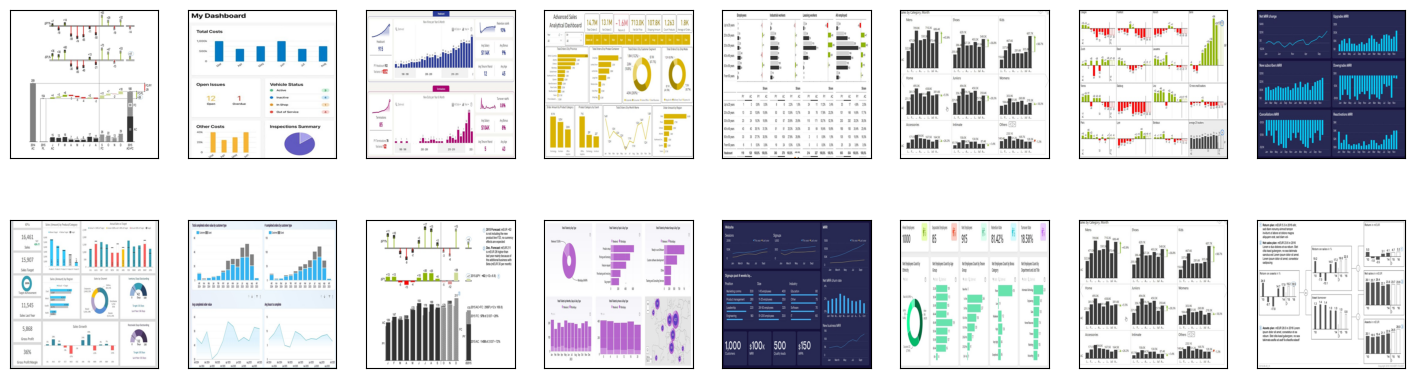

In [4]:
sample_size = 16

plotimgs = copy.deepcopy(images)
np.random.shuffle(plotimgs)
rows = plotimgs[:sample_size]

_, subplots = plt.subplots(nrows = math.ceil(sample_size/8), ncols = 8, figsize=(18, int(sample_size/3)))
subplots = subplots.flatten()
for i, x in enumerate(rows):
    subplots[i].imshow(np.reshape(x, [size, size, 3]))
    subplots[i].set_xticks([])
    subplots[i].set_yticks([])

## Stratified Train-Test Split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=.3, random_state=42, stratify=labels)

def print_class_counts(y, set_name):
    classes, counts = np.unique(y, return_counts=True)
    print(f"{set_name} set:")
    for cls, count in zip(classes, counts):
        print(f"  {cls}: {count}")
    print()

print_class_counts(y_train, "Train")
print_class_counts(y_test, "Test")

Train set:
  Compliant: 14
  Not Compliant: 14

Test set:
  Compliant: 7
  Not Compliant: 6



## Use pre-trained ConvNeXt 
Using the ConvNeXt Tiny model for image classification with PyTorch. 

In [6]:
num_classes = len(np.unique(labels))    
model = models.convnext_tiny(pretrained=True)
print(f"Model loaded with {num_classes} output classes")

c:\Users\nguye\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nguye\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model loaded with 2 output classes


## Label Encoding
Neural networks need numeric labels, not strings. I creates a mapping: {'compliant': 0, 'non-compliant': 1} text labels -> numerical values 

In [7]:
label_map = {label: idx for idx, label in enumerate(np.unique(labels))}
inverse_label_map = {idx: label for label, idx in label_map.items()}

y_train_numeric = np.array([label_map[label] for label in y_train])
y_test_numeric = np.array([label_map[label] for label in y_test])

print(f"Label mapping: {label_map}")
print(f"Inverse label mapping: {inverse_label_map}")

Label mapping: {np.str_('Compliant'): 0, np.str_('Not Compliant'): 1}
Inverse label mapping: {0: np.str_('Compliant'), 1: np.str_('Not Compliant')}


## Convert to PyTorch Tensors
### Why using PyTorch?
PyTorch tensors are multi - dimensional arrays that can be used on both CPUs and GPUs. They are similar to NumPy arrays but have additional features like automatic differentiation and the ability to run on GPUs, which makes them suitable for deep learning applications.

=> Change format to PyTorch

FloatTensor: Converts numpy arrays to PyTorch tensors (float32)

LongTensor: Integer labels (required for classification)

In [8]:
# Reshape to PyTorch format 
X_train_torch = torch.FloatTensor(X_train).reshape(-1, 3, size, size)
X_test_torch = torch.FloatTensor(X_test).reshape(-1, 3, size, size)
y_train_torch = torch.LongTensor(y_train_numeric)
y_test_torch = torch.LongTensor(y_test_numeric)

print(f"Train data shape: {X_train_torch.shape}")
print(f"Test data shape: {X_test_torch.shape}")
print(f"Train labels shape: {y_train_torch.shape}") 
print(f"Test labels shape: {y_test_torch.shape}")

Train data shape: torch.Size([28, 3, 300, 300])
Test data shape: torch.Size([13, 3, 300, 300])
Train labels shape: torch.Size([28])
Test labels shape: torch.Size([13])


## Create DataLoaders
### What is DataLoader
A DataLoader in PyTorch simplifies the process of loading and batching data for training deep learning models. It works with datasets to provide efficient data handling, including batching, shuffling, and parallel loading.

=> Efficiently feed data during training

TensorDataset: Pairs images with their labels

DataLoader:
- Batches data (feeds 32 images at a time to the model)
- Shuffles training data each epoch (prevents learning order patterns)
- Doesn't shuffle test data (order doesn't matter for evaluation)

In [9]:
train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

batch_size = 16  # Reduce if get out of memory errors
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Training Function
Loss Function: CrossEntropyLoss – measures the difference between predicted and actual classes

Optimizer: Adam with learning rate 0.0001 – adjusts model weights efficiently

Device: Uses GPU if available; otherwise defaults to CPU

Now, we have training loop looks like: 
1. Forward pass -> Get model predictions
2. Compute loss
3. Backward pass -> Calculate gradients 
4. Update  weights 
5. Track accuracy and loss per epoch

In [10]:
def train_model(model, train_loader, criterion, device, optimizer, epochs=10):
    model.train()
    
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad() # clear old gradients
            outputs = model(inputs)
            loss = criterion(outputs, labels) # compute loss
            loss.backward() # backpropagate, calculate gradients for each parameter
            optimizer.step() # update weights using gradients
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')

In [11]:
def evaluate_model(model, test_loader, device):
    model.eval()
    all_predictions = []
    all_labels = []
    
    with torch.no_grad(): # during evaluation, we don't need to compute gradients
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return np.array(all_predictions), np.array(all_labels)

 ## Model Setup and Training
 ### Compatibility with GPU
If working on a GPU, make sure to move the integer tensors to the GPU before performing operations.



In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

Using device: cpu


In [13]:
print("Training model: ")
train_model(model, train_loader, criterion, device, optimizer,  epochs=10)

Training model: 
Epoch [1/10], Loss: 7.2252, Accuracy: 0.00%
Epoch [2/10], Loss: 3.2734, Accuracy: 53.57%
Epoch [3/10], Loss: 0.7825, Accuracy: 71.43%
Epoch [4/10], Loss: 0.6050, Accuracy: 78.57%
Epoch [5/10], Loss: 0.2418, Accuracy: 89.29%
Epoch [6/10], Loss: 0.2354, Accuracy: 92.86%
Epoch [7/10], Loss: 0.1797, Accuracy: 92.86%
Epoch [8/10], Loss: 0.1097, Accuracy: 96.43%
Epoch [9/10], Loss: 0.0550, Accuracy: 100.00%
Epoch [10/10], Loss: 0.0249, Accuracy: 100.00%


In [14]:

print("Evaluation: ")
predictions, true_labels = evaluate_model(model, test_loader, device)

# Accuracy
accuracy = (predictions == true_labels).sum() / len(true_labels)
print(f"Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

Evaluation: 
Test Accuracy: 0.8462 (84.62%)


In [15]:

# Classification Report
predictions_labels = [inverse_label_map[pred] for pred in predictions]
true_labels_labels = [inverse_label_map[label] for label in true_labels]
report = classification_report(true_labels_labels, predictions_labels)
print("\nClassification Report:")
print(report)


Classification Report:
               precision    recall  f1-score   support

    Compliant       1.00      0.71      0.83         7
Not Compliant       0.75      1.00      0.86         6

     accuracy                           0.85        13
    macro avg       0.88      0.86      0.85        13
 weighted avg       0.88      0.85      0.84        13



After training, we test the model on confusion matrix.

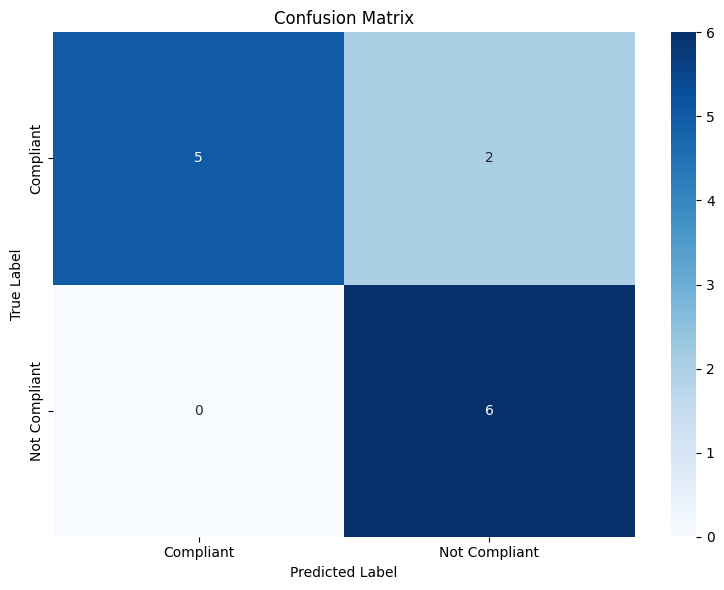

In [16]:
# Confusion Matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(inverse_label_map.values()),
            yticklabels=list(inverse_label_map.values()))
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

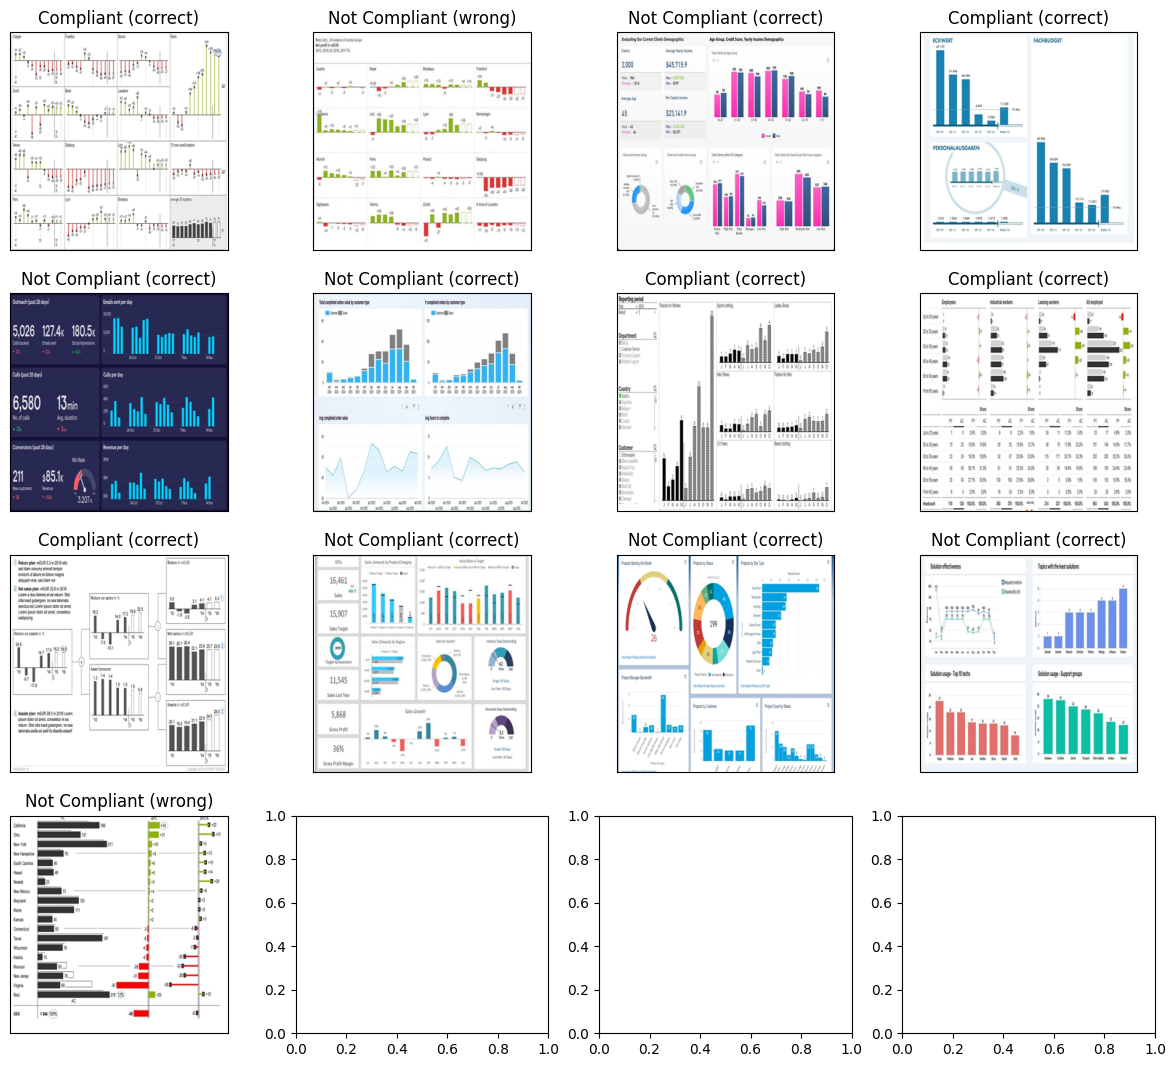

In [17]:
_, subplots = plt.subplots(nrows = math.ceil(len(X_test)/4), ncols = 4, figsize=(15, len(X_test)))
subplots = subplots.flatten()
for i, x in enumerate(X_test):  
    subplots[i].imshow(np.reshape(x, [size, size, 3]))
    subplots[i].set_xticks([])
    subplots[i].set_yticks([])
    pred_label = inverse_label_map[predictions[i]]
    true_label = y_test[i]
    is_correct = pred_label == true_label

    subplots[i].set_title(pred_label + (" (correct)" if is_correct else " (wrong)"))

## Conclusion
The model learned the training data too well, Training accuracy reached 100%, but test accuracy stayed around 85%.
This is why the model performs perfectly during training but makes a few mistakes on the test set - a classic symptom of overfitting.

In [4]:

import os, torch
from torchvision import models as models
save_dir = "Checkpoints"
os.makedirs(save_dir, exist_ok=True)

model = models.convnext_tiny(pretrained=True)
convnext_path = os.path.join(save_dir, "convnext.pt")
torch.save(model.state_dict(), convnext_path)
print("Model saved at: ", convnext_path)

c:\Users\nguye\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nguye\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model saved at:  Checkpoints\convnext.pt
